In [1]:
# Let's make a rotator distribution where we just pick a rotation angle to maintain each night. See if that results in something better

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import calcLmstLast, Site
np.random.seed(42)

In [3]:
class FlatAngleDist(metrics.BaseMetric):
    """Measure how flat a distribution of angles is"""
    def __init__(self, col=None, angle_range=[-180,180], metricName='FlatAngleDist', **kwargs):
        self.col = col
        self.angle_range = angle_range
        super(FlatAngleDist, self).__init__(col=col, metricName=metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        ord = np.argsort(dataSlice[self.col])
        cumulative_observed = np.arange(dataSlice[self.col].size)+1
        slope = dataSlice[self.col].size/(np.max(self.angle_range)-np.min(self.angle_range))
        # Bah, assume range is symetric
        # XXX---I don't think this is working right yet--need to run a unit test on it
        cumulative_expected = slope*dataSlice[self.col][ord] 
        diff_frac = (cumulative_observed-cumulative_expected)/float(dataSlice[self.col].size)
        return np.max(diff_frac)

In [4]:
#runName = 'astro-lsst-01-2013'
#conn = db.OpsimDatabase('astro-lsst-01_2013.db')
conn  = db.Database('feature_baseline_10yrs.db', defaultTable='observations')
outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
class LSTStacker(stackers.BaseStacker):
    def __init__(self, mjdCol='mjd', site='LSST'):
        self.mjdCol = mjdCol
        self.site = Site(name=site)
        self.colsReq = [mjdCol]
        self.colsAdded = ['lst']
        self.units = ['degrees']
        
    def _run(self, simData):
        lmst, last = calcLmstLast(simData[self.mjdCol], self.site.longitude_rad)
        simData['lst'] = lmst*360./24.
        return simData

In [6]:
# Now to make a new stacker that randomizes rotSkyPos per night, and then recalc the rotTelPos
class RandRotSkyPos(stackers.BaseStacker):
    def __init__(self, raCol='fieldRA', decCol='fieldDec', degrees=True, mjdCol='observationStartMJD',
                 lstCol=None, 
                 nightCol='night', site='LSST', nightMap=None):
        """
        Parameters
        ----------
        nightMap : np.array
            Array where each element is the rotation angle to set rotTelPos each night (in degrees).
        """
        self.units = 'degrees'
        self.lstCol = lstCol
        self.raCol = raCol
        self.decCol = decCol
        self.degrees = degrees
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.nightMap = nightMap
        self.colsReq = [self.raCol, self.decCol, self.mjdCol, self.nightCol]
        
        self.colsAdded = ['rotTelPos', 'rotSkyPos', 'PA', 'HA']
        if lstCol is None:
            self.LST_stacker = LSTStacker(site=site, mjdCol=mjdCol)
            lstCol = 'lst'
            self.colsAdded.append('lst')
        else:
            self.LST_stacker = None
            self.colsReq.append(lstCol)
            
        self.PA_stacker = stackers.ParallacticAngleStacker(raCol=raCol, decCol=decCol, degrees=degrees,
                                                          mjdCol=mjdCol, lstCol=lstCol, site=site)
        
    def _run(self, simData, cols_present=False):
        if self.LST_stacker is not None:
            simData = self.LST_stacker._run(simData)
        simData = self.PA_stacker._run(simData)
        if self.nightMap is None:
            self.nightMap = np.random.rand(simData[self.nightCol].max()+1)*180.-90.
        temp, index_map = np.unique(simData[self.nightCol], return_inverse=True)
        simData['rotTelPos'] = self.nightMap[index_map]
        simData['rotSkyPos'] = simData['rotTelPos'] - simData['PA']
        # This is the angle between up on the detector and North on the sky. So I think plus/minus 180 degrees
        simData['rotSkyPos'][np.where(simData['rotSkyPos'] < -180.)] += 360.
        simData['rotSkyPos'][np.where(simData['rotSkyPos'] > 180.)] -= 360.
        
        return simData
        

In [7]:
bundleList = []
stacker = RandRotSkyPos(raCol='RA', decCol='dec', mjdCol='mjd', lstCol=None)

metric = metrics.RmsAngleMetric(col='rotSkyPos')
slicer = slicers.HealpixSlicer(nside=64, latCol='dec', lonCol='RA')
sql = 'filter ="i"'

bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker])
bundleList.append(bundle)
metric = metrics.FullRangeAngleMetric(col='rotSkyPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))

metric=metrics.MeanAngleMetric(col='rotSkyPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))


metric=FlatAngleDist(col='rotSkyPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database observations with constraint filter ="i" for columns ['mjd', 'RA', 'night', 'dec']
Found 506598 visits
Running:  ['opsim_RmsAngle_rotSkyPos_i_HEAL', 'opsim_FullRangeAngle_rotSkyPos_i_HEAL', 'opsim_MeanAngle_rotSkyPos_i_HEAL', 'opsim_FlatAngleDist_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter ="i"" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 204 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 55.5357  dipole: lon: 135.522, lat: -57.5725, amp: 9.09379
monopole: 206.528  dipole: lon: 147.571, lat: -68.6135, amp: 55.4631
monopole: 174.953  dipole: lon: 131.94, lat: -22.6545, amp: 46.4585
monopole: 0.730422  dipole: lon: 179.992, lat: 42.4566, amp: 0.0834883
Plotting complete.


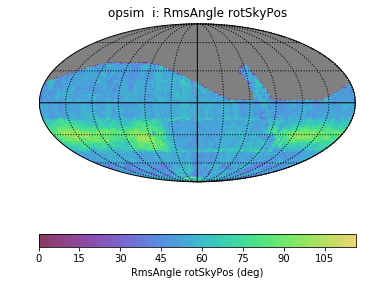

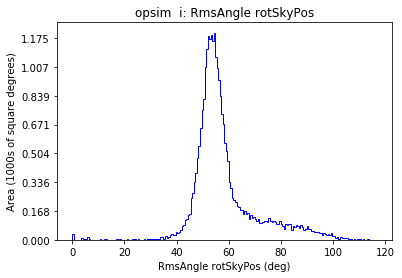

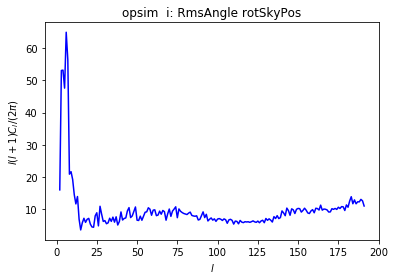

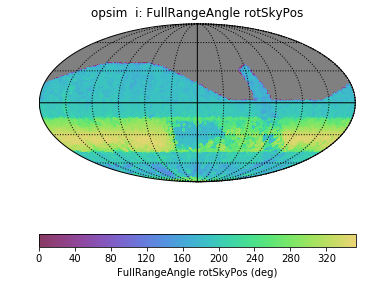

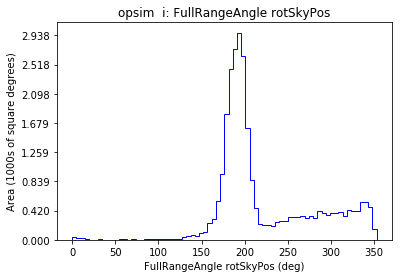

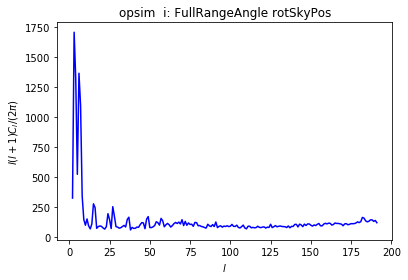

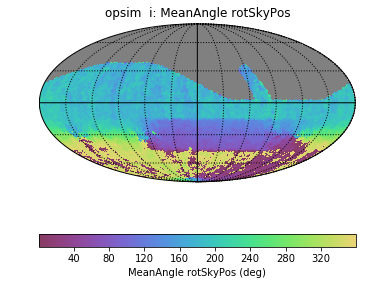

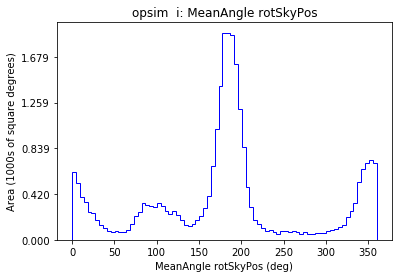

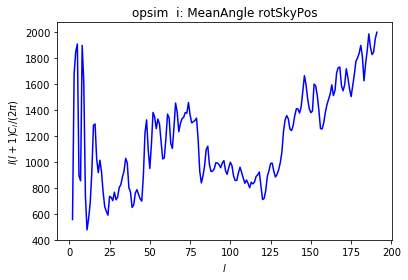

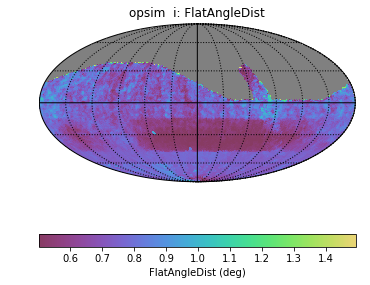

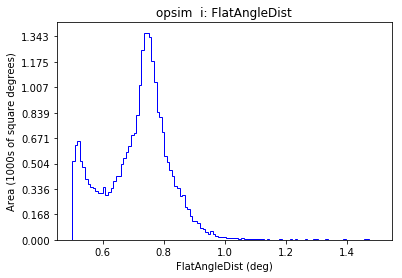

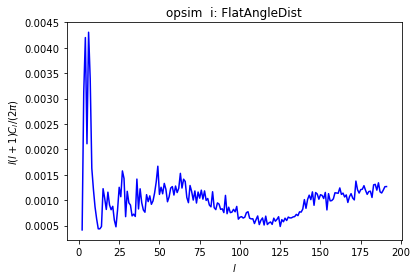

In [8]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, conn, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [9]:
bundleList = []
stacker = RandRotSkyPos(raCol='RA', decCol='dec', mjdCol='mjd', lstCol=None)

metric = metrics.RmsAngleMetric(col='rotTelPos')
slicer = slicers.HealpixSlicer(nside=64, latCol='dec', lonCol='RA')
sql = 'filter ="i"'

bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker])
bundleList.append(bundle)
metric = metrics.FullRangeAngleMetric(col='rotTelPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))

metric=metrics.MeanAngleMetric(col='rotTelPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))


metric=FlatAngleDist(col='rotTelPos', angle_range=[-90, 90])
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database observations with constraint filter ="i" for columns ['mjd', 'RA', 'night', 'dec']
Found 506598 visits
Running:  ['opsim_RmsAngle_rotTelPos_i_HEAL', 'opsim_FullRangeAngle_rotTelPos_i_HEAL', 'opsim_MeanAngle_rotTelPos_i_HEAL', 'opsim_FlatAngleDist_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter ="i"" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 304 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 48.3404  dipole: lon: 118.071, lat: -61.0291, amp: 4.374


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 403 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 167.064  dipole: lon: 105.8, lat: -64.0199, amp: 9.82915
monopole: 182.168  dipole: lon: 31.6541, lat: -55.2035, amp: 25.6076


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 205 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.604294  dipole: lon: -47.8729, lat: 21.2069, amp: 0.0181997
Plotting complete.


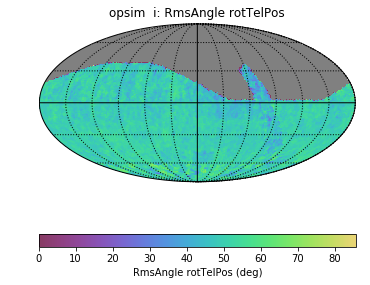

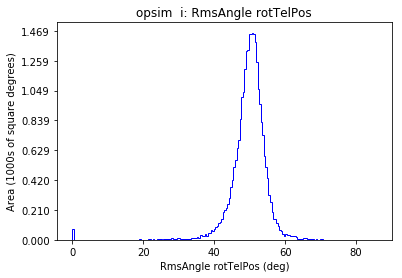

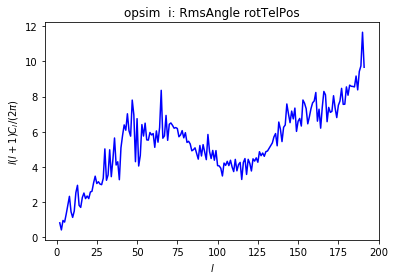

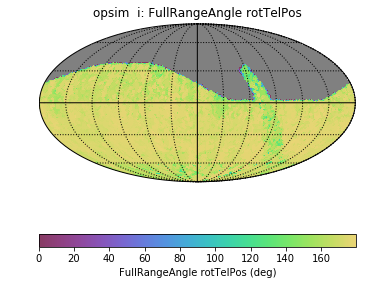

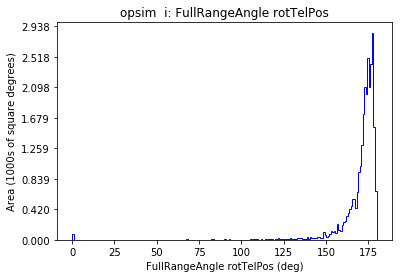

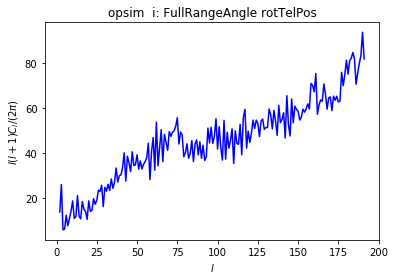

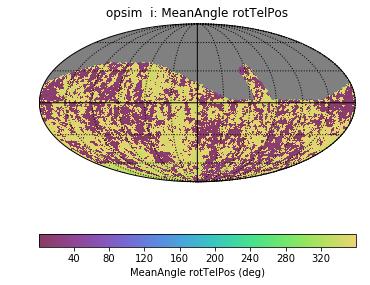

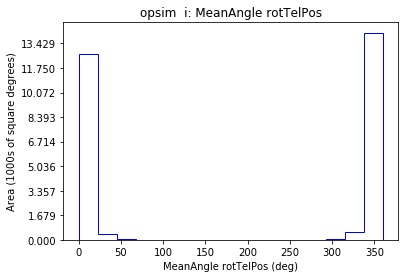

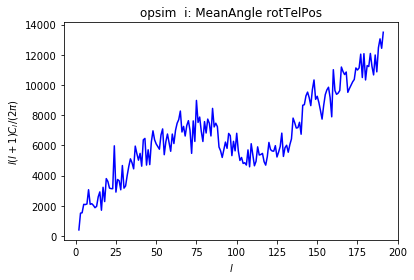

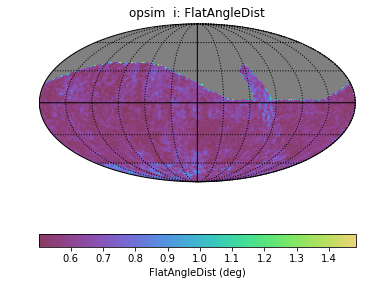

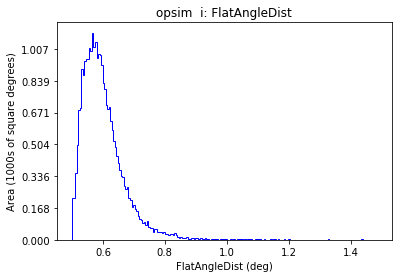

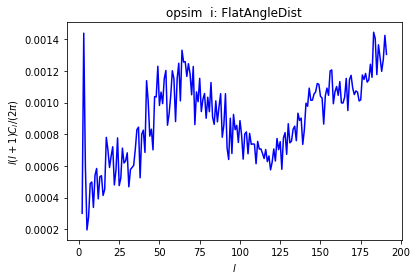

In [10]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, conn, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [11]:
# I don't think I understand the angle metrics, let's look at it
bundleList = []
slicer = slicers.UserPointsSlicer(ra=0, dec=-50, lonCol='RA', latCol='dec')
metric = metrics.PassMetric(cols=['rotTelPos', 'rotSkyPos'])
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker]))

In [12]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, conn, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database observations with constraint filter ="i" for columns ['mjd', 'RA', 'night', 'dec']
Found 506598 visits
Running:  ['opsim_Pass_rotTelPos_rotSkyPos_i_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


(array([  0.,   0.,   0.,   0.,   0.,  30.,  41.,  22.,  32.,  47.,  16.,
         14.,  24.,   2.,   0.,   0.,   0.,   0.]),
 array([-190, -170, -150, -130, -110,  -90,  -70,  -50,  -30,  -10,   10,
          30,   50,   70,   90,  110,  130,  150,  170]),
 <a list of 18 Patch objects>)

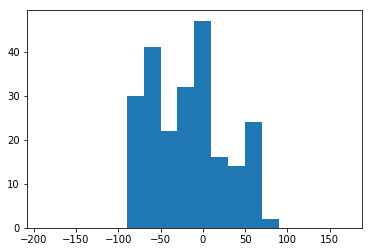

In [13]:
plt.hist(bundleList[0].metricValues[0]['rotTelPos'], bins=np.arange(-190,190,20))

In [14]:
mets =[metrics.MeanAngleMetric(col='rotTelPos'), metrics.RmsAngleMetric('rotTelPos'),
          metrics.FullRangeAngleMetric('rotTelPos')]
for func in mets:
          print(func.run(bundleList[0].metricValues[0]))

339.125621282
43.7736113245
176.364743871


In [15]:
data = bundleList[0].metricValues[0]['rotTelPos']
x = np.cos(np.radians(data))
y = np.sin(np.radians(data))
meanx = np.mean(x)
meany = np.mean(y)
angle = np.arctan2(meany, meanx)
radius = np.sqrt(meanx**2 + meany**2)
mean = angle % (2.*np.pi)